In [1]:
# This lets us refresh changes from other .py files without having to restart the notebook
%load_ext autoreload 
%autoreload 2

In [13]:
from blocks import *
import torch
import torchvision.transforms.v2 as v2
from utils import validateModelIO, profileModel
from torch.profiler import profile, record_function, ProfilerActivity

# Import model and transform variables
from models import *
from transforms import *
from utils import getModel

import matplotlib.pyplot as plt
import numpy as np



Using device: cuda
Got model: jesseNetv5
Using device: cuda
Test passed!
_Conv2d 0 295 1034 32.0
_BatchNorm2d 1 212 117 32.001
_PReLU 2 103 208 32.0
_MaxPool2d 3 89 33 24.0
_BranchBlock 4 8223 7980 357.024
_Conv2d 5 171 141 32.0
_BatchNorm2d 6 155 83 32.001
_PReLU 7 86 55 32.0
_BranchBlock 8 7979 8724 1424.024
_MaxPool2d 9 86 51 24.0
_BranchBlock 10 7875 7498 356.024
_Conv2d 11 154 346 32.0
_BatchNorm2d 12 168 87 32.004
_PReLU 13 80 62 32.0
_MaxPool2d 14 66 37 24.0
_HighwayBlock 15 50325 50440 2136.398
_AvgPool2d 16 65 12 0.5
_Flatten 17 38 10 0.0
_Linear 18 134 43 0.062
_LayerNorm 19 101 33 0.064
_PReLU 20 90 28 0.062
_Linear 21 118 37 0.01


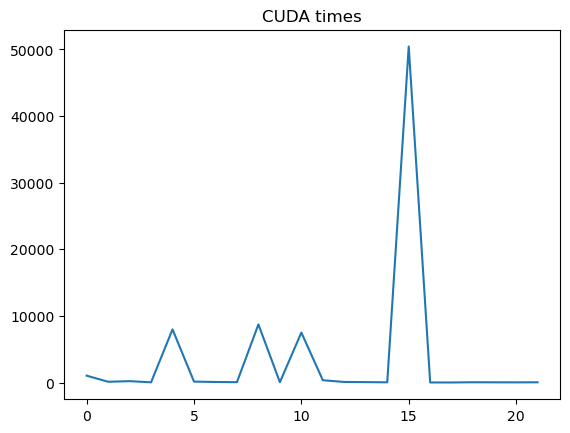

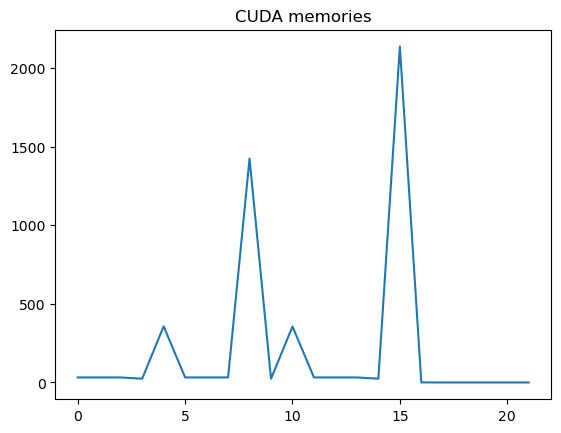

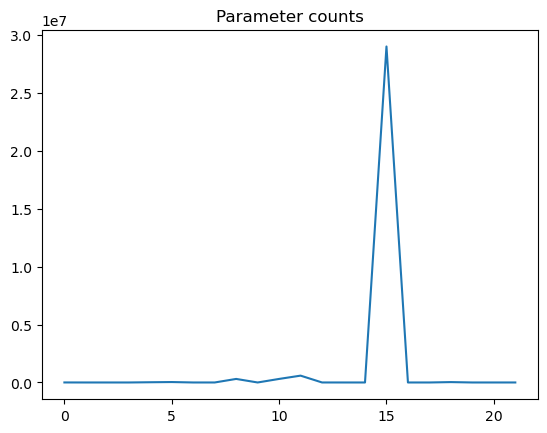

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         [memory]         0.00%       0.000us         0.00%       0.000us       0.000us       0.000us         0.00%       0.000us       0.000us           0 b           0 b      -4.53 Gb      -4.53 Gb          1082            --  
              

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Default arguments for simple testing
modelName = 'jesseNetv5_easyaugment'
batch_size = 256

input_size = (batch_size, 3, 32, 32)
randomInput = torch.randn(input_size, device=device, dtype=torch.float)

model = getModel(modelName)
model = model.to(device)


try:
    validateModelIO(model=ResidualCNN(network=model, printOutsize=False), printSummary=False)
except Exception as e:
    print(f'{modelName} failed validation!')
    raise e



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], with_flops=True, with_modules=True, record_shapes=True, profile_memory=True) as profilerContext:
    
    output = randomInput
    for i, layer in enumerate(model.children()):
        with record_function(f"_{type(layer).__name__} {i}"):
            output = layer(output)

originalEvents = profilerContext.key_averages()


# Filter events whose names start with 'Layer'
events = [event for event in originalEvents if event.key.startswith('_')]

attributesList = []

assert len(list(model.children())) == len(events)

for event, layer in zip(events, model.children()):
    cpu_time = event.cpu_time_total
    cuda_time = event.cuda_time_total
    cuda_memory_usage = round(event.cuda_memory_usage / (1024**2), 3)
    param_count = sum([p.numel() for p in layer.parameters()])
    
    attributesList.append({
        'cpu_time': cpu_time,
        'cuda_time': cuda_time,
        'cuda_memory_usage': cuda_memory_usage,
        'param_count': param_count
    })
    
    print(event.key, cpu_time, cuda_time, cuda_memory_usage)

cudaTimes = [attr['cuda_time'] for attr in attributesList]    
cudaMemories = [attr['cuda_memory_usage'] for attr in attributesList]
param_counts = [attr['param_count'] for attr in attributesList]

plt.plot(range(len(attributesList)), cudaTimes), plt.title('CUDA times'), plt.show()
plt.plot(range(len(attributesList)), cudaMemories), plt.title('CUDA memories'), plt.show()
plt.plot(range(len(attributesList)), param_counts), plt.title('Parameter counts'), plt.show()

# Convert the filtered events back into an EventList
# events = torch.autograd.profiler_util.EventList(events)

outputTable = originalEvents.table()
print(outputTable)

+------------------+------------+------------------+--------------------------+-------------------+
|                  |   CPU Time |   CUDA Time (ms) |   CUDA Memory Usage (MB) |   Parameter Count |
+==================+============+==================+==========================+===================+
| _Conv2d 0        |        239 |               99 |                   32     |              2432 |
| _BatchNorm2d 1   |        199 |              115 |                   32.001 |                64 |
| _PReLU 2         |         88 |               52 |                   32     |                 1 |
| _MaxPool2d 3     |         68 |               40 |                   24     |                 0 |
| _BranchBlock 4   |       7670 |             7568 |                  356.024 |             20228 |
| _Conv2d 5        |        159 |              140 |                   32     |             36992 |
| _BatchNorm2d 6   |        161 |              386 |                   32.001 |               256 |


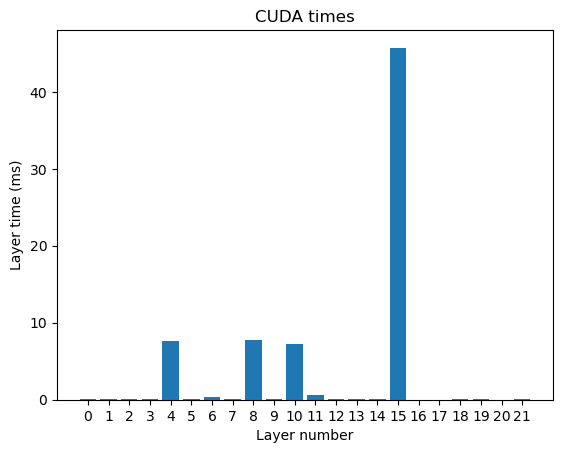

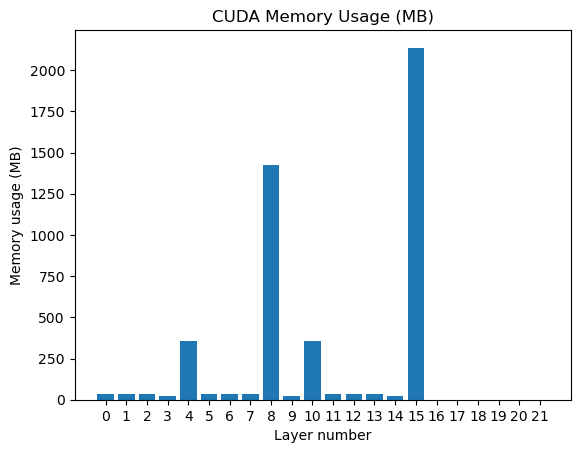

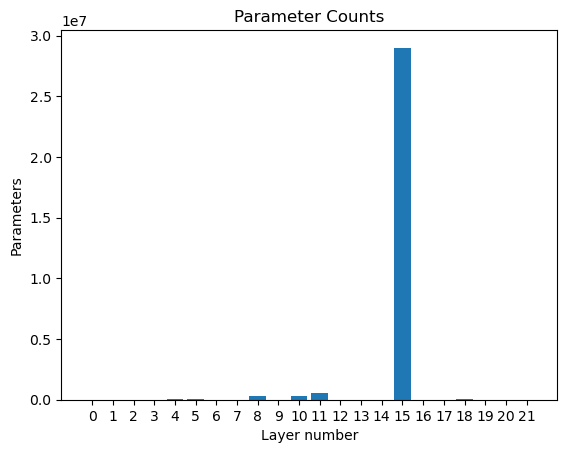

In [19]:
profileModel(model=model, input_size=input_size)